In [5]:
# Load Libraries
import os
import PIL
import numpy as np
import torch
import glob
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam,SGD
from torch.optim import lr_scheduler
from torch.utils.data import ConcatDataset
from torch.autograd import Variable
import torchvision
import pathlib
from torchvision import datasets, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch._utils_internal
import time

from torchsummary import summary

device = torch.device('mps' if torch.has_mps else 'cpu')

In [6]:
torch.has_mps

True

In [7]:
print(device)

mps


In [8]:
aug_transforms = transforms.Compose([
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15),
#                       transforms.RandomRotation([90, 180, 270]),
                      transforms.Resize([224, 224]),
#                       transforms.RandomCrop([28, 28]),
                      transforms.ToTensor(),
                     
                  ])
image_datasets = datasets.ImageFolder('/Users/jiaulhaquesaboj/Documents/Deep-Learning-Project/AMD/AMD/Training400', aug_transforms)
print(len(image_datasets))

class_names = image_datasets.classes
print(class_names)

399
['AMD', 'Non-AMD']


In [9]:
datasets = {}
train_idx, test_idx = train_test_split(list(range(len(image_datasets))), test_size=0.2)
datasets['test'] = torch.utils.data.Subset(image_datasets, test_idx)
train_set = torch.utils.data.Subset(image_datasets, train_idx)
train_idx, val_idx = train_test_split(list(range(len(train_set))), test_size=0.25)
datasets['val'] = torch.utils.data.Subset(image_datasets, val_idx)
datasets['train'] = torch.utils.data.Subset(image_datasets, train_idx)
print(len(datasets['train']), len(datasets['val']), len(datasets['test']))

239 80 80


In [10]:
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], 128, shuffle=True) for x in ['train','val','test']}
x, y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

torch.Size([128, 3, 224, 224]) torch.Size([128])


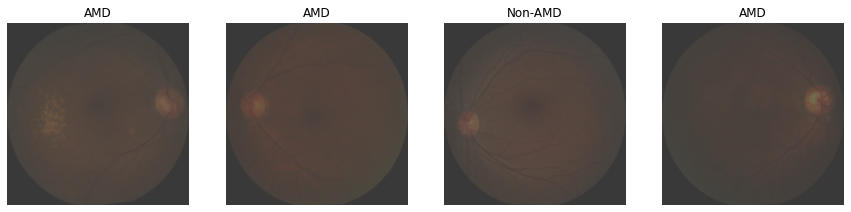

In [11]:
images, labels = next(iter(dataloaders['train']))
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    imgs = images[i].numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + std
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    plt.axis('off')
    plt.title(class_names[labels[i]])

In [12]:
def train_model(model, criterion, optimizer, lr_scheduler, epochs=50):
    train_start = time.time()
    history = []
    best_acc = 0.0
    
    for epoch in range(epochs):
        epoch_start = time.time()
        train_loss, train_acc, val_loss, val_acc = 0.0, 0.0, 0.0, 0.0        
        
        model.train()
        for (inputs, labels) in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)
            
        lr_scheduler.step()
            
        with torch.no_grad():
            model.eval()
            
            for (inputs, labels) in dataloaders['val']:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data)
        
        train_loss /= len(datasets['train'])
        train_acc /= len(datasets['train'])
        val_loss /= len(datasets['val'])
        val_acc /=  len(datasets['val'])
        history.append([train_loss, train_acc, val_loss, val_acc])
        
        print("Epoch : {}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss : {:.4f}, val_acc: {:.4f}, Time: {:.4f}s".format(epoch+1, train_loss, train_acc, val_loss, val_acc, time.time()-epoch_start))
    return model, history

In [13]:
alexnet = models.alexnet(pretrained=True)
for param in alexnet.parameters():
    param.requires_grad = False
    
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = torch.nn.Linear(num_features, len(class_names))
alexnet = alexnet.to(device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/Users/jiaulhaquesaboj/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/jiaulhaquesaboj/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
trained_model, history = train_model(alexnet, loss_func, optimizer, lr_scheduler, epochs=50)

Epoch : 1, train_loss: 4.0526, train_acc: 0.6192, val_loss : 0.9494, val_acc: 0.6375, Time: 45.4651s
Epoch : 2, train_loss: 4.6763, train_acc: 0.7531, val_loss : 0.8772, val_acc: 0.6375, Time: 33.9921s
Epoch : 3, train_loss: 4.3806, train_acc: 0.7531, val_loss : 0.6511, val_acc: 0.6375, Time: 33.7734s
Epoch : 4, train_loss: 2.0786, train_acc: 0.7197, val_loss : 0.8610, val_acc: 0.3500, Time: 33.5888s
Epoch : 5, train_loss: 2.5356, train_acc: 0.5314, val_loss : 0.9959, val_acc: 0.3625, Time: 33.8101s
Epoch : 6, train_loss: 2.6033, train_acc: 0.5230, val_loss : 0.9732, val_acc: 0.3750, Time: 33.7697s
Epoch : 7, train_loss: 2.1710, train_acc: 0.5272, val_loss : 0.9075, val_acc: 0.4000, Time: 33.7762s
Epoch : 8, train_loss: 1.8667, train_acc: 0.5523, val_loss : 0.8391, val_acc: 0.4125, Time: 34.3180s
Epoch : 9, train_loss: 1.5683, train_acc: 0.6192, val_loss : 0.7749, val_acc: 0.4500, Time: 33.5417s
Epoch : 10, train_loss: 1.2683, train_acc: 0.6485, val_loss : 0.7195, val_acc: 0.5000, Time

In [15]:
train_loss = [h[0] for h in history]
train_acc = [h[1].cpu() for h in history]
val_loss = [h[2] for h in history]
val_acc = [h[3].cpu() for h in history]

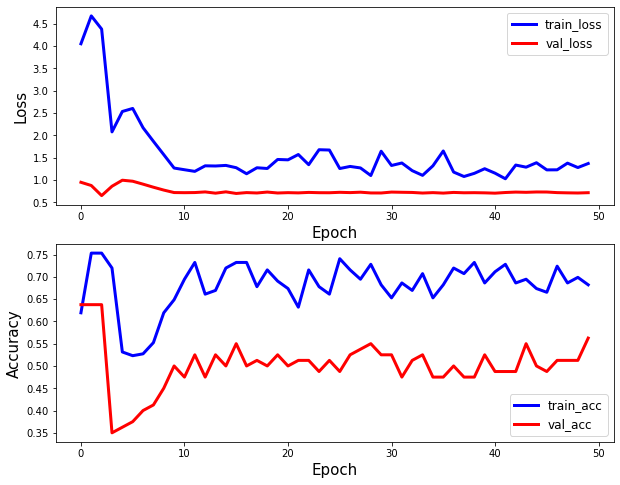

In [16]:
def plot_model_history(history):
    x = np.arange(len(history))
    fig = plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(x, train_loss, label='train_loss', lw=3, c="b")
    plt.plot(x, val_loss, label='val_loss', lw=3, c="r")
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.subplot(2, 1, 2)
    plt.plot(x, train_acc, label='train_acc', lw=3, c="b")
    plt.plot(x, val_acc, label='val_acc', lw=3, c="r")
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Accuracy", fontsize=15)
    plt.show()

plot_model_history(history)

In [17]:
def evaluation_model(model):
    top1 = 0
    top3 = 0
    N = len(datasets['test'])
    for (inputs, labels) in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        outputs = torch.nn.functional.softmax(outputs, dim=-1)
        _, indices = torch.topk(outputs, 3, dim=-1)
        for i in range(len(indices)):
            for j in range(3):
                if indices[i,j] == labels[i]:
                    top3 += 1
                    break
            top1 += 1 if indices[i,0]==labels[i] else 0
    print("Top-1 accuracy: {:.2f}%".format(100*top1/N))
    print("Top-3 accuracy: {:.2f}%".format(100*top3/N))    

In [18]:
evaluation_model(trained_model)

RuntimeError: selected index k out of range

In [ ]:
images, labels = next(iter(dataloaders['test']))
images = images.to(device)
outputs = trained_model(images)
_, indices = torch.max(outputs, -1)

plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4, 5, i+1)
    imgs = images[i].cpu().numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + std
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    plt.axis('off')
    title = f"Predicted: {class_names[indices[i]]}\nTrue label: {class_names[labels[i]]}"
    plt.title(title)

In [ ]:
# torch.save(trained_model.state_dict(), 'model.pt')